<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 307, '日付': '2021-02-12T08:00:00.000Z'},
 {'小計': 369, '日付': '2021-02-13T08:00:00.000Z'},
 {'小計': 371, '日付': '2021-02-14T08:00:00.000Z'},
 {'小計': 266, '日付': '2021-02-15T08:00:00.000Z'},
 {'小計': 350, '日付': '2021-02-16T08:00:00.000Z'},
 {'小計': 378, '日付': '2021-02-17T08:00:00.000Z'},
 {'小計': 445, '日付': '2021-02-18T08:00:00.000Z'},
 {'小計': 353, '日付': '2021-02-19T08:00:00.000Z'},
 {'小計': 327, '日付': '2021-02-20T08:00:00.000Z'},
 {'小計': 272, '日付': '2021-02-21T08:00:00.000Z'},
 {'小計': 178, '日付': '2021-02-22T08:00:00.000Z'},
 {'小計': 275, '日付': '2021-02-23T08:00:00.000Z'},
 {'小計': 213, '日付': '2021-02-24T08:00:00.000Z'},
 {'小計': 340, '日付': '2021-02-25T08:00:00.000Z'},
 {'小計': 270, '日付': '2021-02-26T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-02-22 17:00:00+09:00,264,0,178,2021-02-22 17:00:00+09:00
2021-02-23 17:00:00+09:00,235,0,275,2021-02-23 17:00:00+09:00
2021-02-24 17:00:00+09:00,237,0,213,2021-02-24 17:00:00+09:00
2021-02-25 17:00:00+09:00,213,0,340,2021-02-25 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-02-22 17:00:00+09:00,264,0,178,2021-02-22 17:00:00+09:00,240.000000,1680.0,0.0,0.0,329.000000,2303.0
2021-02-23 17:00:00+09:00,235,0,275,2021-02-23 17:00:00+09:00,237.142857,1660.0,0.0,0.0,318.285714,2228.0
2021-02-24 17:00:00+09:00,237,0,213,2021-02-24 17:00:00+09:00,236.571429,1656.0,0.0,0.0,294.714286,2063.0
2021-02-25 17:00:00+09:00,213,0,340,2021-02-25 17:00:00+09:00,236.000000,1652.0,0.0,0.0,279.714286,1958.0
2021-02-26 17:00:00+09:00,0,0,270,2021-02-26 17:00:00+09:00,207.428571,1452.0,0.0,0.0,267.857143,1875.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-02-12 17:00:00+09:00,311,0,307,2021-02-12 17:00:00+09:00,320.428571,2243.0,0.0,0.0,426.857143,2988.0,'21w06,Fri
2021-02-13 17:00:00+09:00,241,0,369,2021-02-13 17:00:00+09:00,301.428571,2110.0,0.0,0.0,388.285714,2718.0,'21w06,Sat
2021-02-14 17:00:00+09:00,249,0,371,2021-02-14 17:00:00+09:00,295.428571,2068.0,0.0,0.0,380.000000,2660.0,'21w06,Sun
2021-02-15 17:00:00+09:00,307,0,266,2021-02-15 17:00:00+09:00,291.857143,2043.0,0.0,0.0,378.571429,2650.0,'21w07,Mon
2021-02-16 17:00:00+09:00,255,0,350,2021-02-16 17:00:00+09:00,289.285714,2025.0,0.0,0.0,369.714286,2588.0,'21w07,Tue
2021-02-17 17:00:00+09:00,241,0,378,2021-02-17 17:00:00+09:00,276.571429,1936.0,0.0,0.0,353.571429,2475.0,'21w07,Wed
2021-02-18 17:00:00+09:00,217,0,445,2021-02-18 17:00:00+09:00,260.142857,1821.0,0.0,0.0,355.142857,2486.0,'21w07,Thu
2021-02-19 17:00:00+09:00,200,0,353,2021-02-19 17:00:00+09:00,244.285714,1710.0,0.0,0.0,361.714286,2532.0,'21w07,Fri
2021-02-20 17:00:00+09:00,264,0,327,2021-02-20 17:00:00+09:00,247.571429,1733.0,0.0,0.0,355.714286,2490.0,'21w07,Sat
2021-02-21 17:00:00+09:00,239,0,272,2021-02-21 17:00:00+09:00,246.142857,1723.0,0.0,0.0,341.571429,2391.0,'21w07,Sun


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-02-07 17:00:00+09:00,572.000000,4004
2021-02-14 17:00:00+09:00,380.000000,2660
2021-02-21 17:00:00+09:00,341.571429,2391
2021-02-26 17:00:00+09:00,255.200000,1276
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-02-12 17:00:00+09:00,311,0,307,2021-02-12 17:00:00+09:00,320.428571,2243.0,0.0,0.0,426.857143,2988.0,'21w06,Fri,NaN,NaN
2021-02-13 17:00:00+09:00,241,0,369,2021-02-13 17:00:00+09:00,301.428571,2110.0,0.0,0.0,388.285714,2718.0,'21w06,Sat,NaN,NaN
2021-02-14 17:00:00+09:00,249,0,371,2021-02-14 17:00:00+09:00,295.428571,2068.0,0.0,0.0,380.000000,2660.0,'21w06,Sun,380.000000,2660.0
2021-02-15 17:00:00+09:00,307,0,266,2021-02-15 17:00:00+09:00,291.857143,2043.0,0.0,0.0,378.571429,2650.0,'21w07,Mon,NaN,NaN
2021-02-16 17:00:00+09:00,255,0,350,2021-02-16 17:00:00+09:00,289.285714,2025.0,0.0,0.0,369.714286,2588.0,'21w07,Tue,NaN,NaN
2021-02-17 17:00:00+09:00,241,0,378,2021-02-17 17:00:00+09:00,276.571429,1936.0,0.0,0.0,353.571429,2475.0,'21w07,Wed,NaN,NaN
2021-02-18 17:00:00+09:00,217,0,445,2021-02-18 17:00:00+09:00,260.142857,1821.0,0.0,0.0,355.142857,2486.0,'21w07,Thu,NaN,NaN
2021-02-19 17:00:00+09:00,200,0,353,2021-02-19 17:00:00+09:00,244.285714,1710.0,0.0,0.0,361.714286,2532.0,'21w07,Fri,NaN,NaN
2021-02-20 17:00:00+09:00,264,0,327,2021-02-20 17:00:00+09:00,247.571429,1733.0,0.0,0.0,355.714286,2490.0,'21w07,Sat,NaN,NaN
2021-02-21 17:00:00+09:00,239,0,272,2021-02-21 17:00:00+09:00,246.142857,1723.0,0.0,0.0,341.571429,2391.0,'21w07,Sun,341.571429,2391.0


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

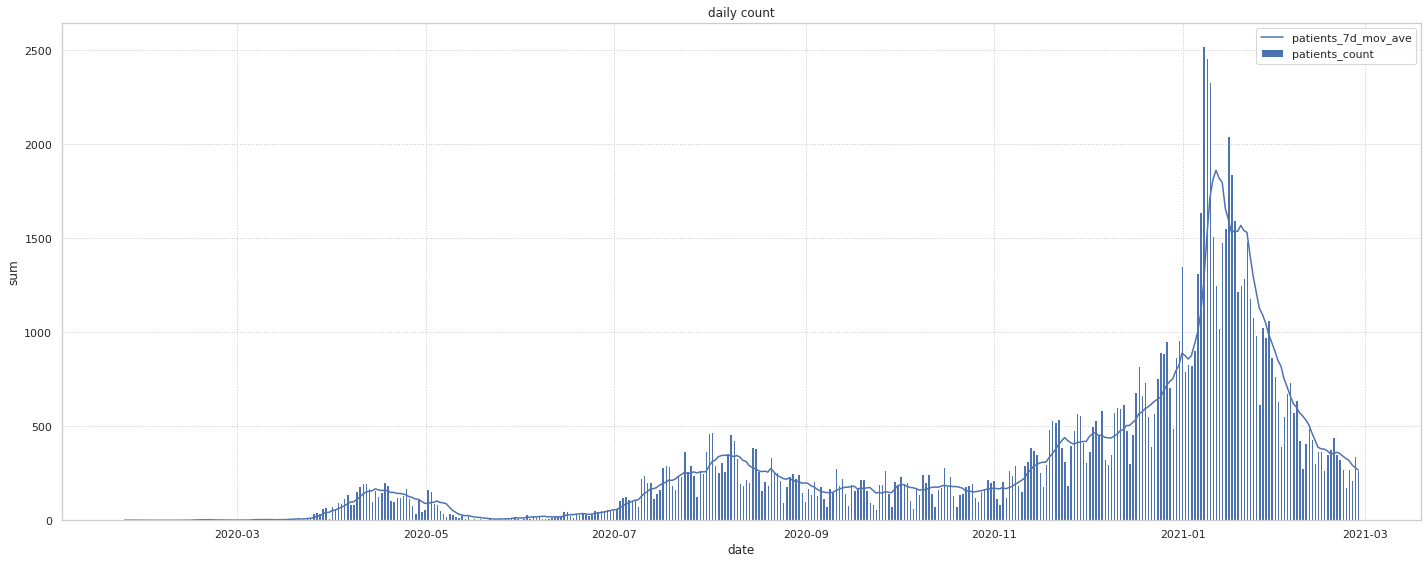

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
385,1.613117e+09,2021,2,12,1,0,0,0,0,0,0,385,0,311,311,320.428571,2243.0,0,0.0,0.0,307,426.857143,2988.0
386,1.613203e+09,2021,2,13,0,0,1,0,0,0,0,386,0,312,241,301.428571,2110.0,0,0.0,0.0,369,388.285714,2718.0
387,1.613290e+09,2021,2,14,0,0,0,1,0,0,0,387,0,313,249,295.428571,2068.0,0,0.0,0.0,371,380.000000,2660.0
388,1.613376e+09,2021,2,15,0,1,0,0,0,0,0,388,0,314,307,291.857143,2043.0,0,0.0,0.0,266,378.571429,2650.0
389,1.613462e+09,2021,2,16,0,0,0,0,0,1,0,389,0,315,255,289.285714,2025.0,0,0.0,0.0,350,369.714286,2588.0
390,1.613549e+09,2021,2,17,0,0,0,0,0,0,1,390,0,316,241,276.571429,1936.0,0,0.0,0.0,378,353.571429,2475.0
391,1.613635e+09,2021,2,18,0,0,0,0,1,0,0,391,0,317,217,260.142857,1821.0,0,0.0,0.0,445,355.142857,2486.0
392,1.613722e+09,2021,2,19,1,0,0,0,0,0,0,392,0,318,200,244.285714,1710.0,0,0.0,0.0,353,361.714286,2532.0
393,1.613808e+09,2021,2,20,0,0,1,0,0,0,0,393,0,319,264,247.571429,1733.0,0,0.0,0.0,327,355.714286,2490.0
394,1.613894e+09,2021,2,21,0,0,0,1,0,0,0,394,0,320,239,246.142857,1723.0,0,0.0,0.0,272,341.571429,2391.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            400 non-null    float64
 1   year                 400 non-null    int64  
 2   month                400 non-null    int64  
 3   day                  400 non-null    int64  
 4   Fri                  400 non-null    uint8  
 5   Mon                  400 non-null    uint8  
 6   Sat                  400 non-null    uint8  
 7   Sun                  400 non-null    uint8  
 8   Thu                  400 non-null    uint8  
 9   Tue                  400 non-null    uint8  
 10  Wed                  400 non-null    uint8  
 11  passed               400 non-null    int64  
 12  emergency            400 non-null    int64  
 13  em_passed            400 non-null    int64  
 14  contacts_count       400 non-null    int64  
 15  contacts_7d_mov_ave  400 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,4.000000e+02,400.0000,400.000000,400.000000,400.000000,400.0000,400.0000,400.0000,400.0000,400.0000,400.0000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,1.597090e+09,2020.1425,6.110000,15.845000,0.145000,0.1425,0.1425,0.1425,0.1425,0.1425,0.1425,199.500000,0.122500,132.437500,730.015000,728.771726,5101.392500,921.297500,921.297500,6449.082500,277.525000,275.521893,1928.612500
std,9.989076e+06,0.3500,3.563657,8.836355,0.352542,0.3500,0.3500,0.3500,0.3500,0.3500,0.3500,115.614301,0.328273,105.959022,460.429656,445.789280,3120.540588,881.540787,769.104478,5383.731346,382.495885,363.128586,2541.931037
min,1.579853e+09,2020.0000,1.000000,1.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.588471e+09,2020.0000,3.000000,8.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,99.750000,0.000000,25.750000,427.250000,444.642857,3112.500000,0.000000,0.000000,0.000000,30.750000,30.071429,210.500000
50%,1.597090e+09,2020.0000,6.000000,16.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,199.500000,0.000000,125.500000,586.500000,600.785714,4205.500000,934.500000,1025.500000,7178.500000,169.000000,167.285714,1171.000000
75%,1.605708e+09,2020.0000,9.000000,24.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,299.250000,0.000000,225.250000,904.500000,909.250000,6364.750000,1514.500000,1499.178571,10494.250000,328.750000,339.535714,2376.750000
max,1.614326e+09,2021.0000,12.000000,31.000000,1.000000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,399.000000,1.000000,325.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.605461,0.347554,0.013358,1.325627e-18,-0.001765,-0.008826,-0.005296,0.008826,0.001765,0.005296,1.000000e+00,-0.328430,0.991676,-0.150126,-0.117348,-0.117342,-0.365250,-0.387485,-0.387485,0.652581,0.697538,0.697557
year,6.054614e-01,1.000000,-0.533030,-0.045515,1.492917e-02,-0.002506,-0.002506,-0.002506,-0.002506,-0.002506,-0.002506,6.054614e-01,-0.152312,0.633909,-0.103343,-0.055450,-0.055448,-0.426571,-0.488932,-0.488932,0.652976,0.731231,0.731229
month,3.475537e-01,-0.533030,1.000000,-0.013306,-1.871214e-02,0.001467,-0.006571,-0.002552,0.011514,0.005486,0.009504,3.475537e-01,-0.167941,0.304585,-0.033629,-0.055394,-0.055389,0.116496,0.168265,0.168265,-0.075485,-0.121156,-0.121131
day,1.335796e-02,-0.045515,-0.013306,1.000000,1.366900e-02,-0.004996,0.001487,-0.000944,0.010401,-0.008237,-0.011479,1.335796e-02,-0.006398,0.016117,-0.027265,-0.024517,-0.024521,-0.001410,-0.021563,-0.021563,-0.012581,0.000661,0.000644
Fri,1.325627e-18,0.014929,-0.018712,0.013669,1.000000e+00,-0.167877,-0.167877,-0.167877,-0.167877,-0.167877,-0.167877,5.242958e-18,-0.002274,0.001786,-0.028176,-0.008829,-0.008827,0.037635,-0.007299,-0.007299,0.048446,-0.002366,-0.002376
Mon,-1.765194e-03,-0.002506,0.001467,-0.004996,-1.678770e-01,1.000000,-0.166181,-0.166181,-0.166181,-0.166181,-0.166181,-1.765194e-03,0.000382,-0.001888,0.043751,0.001242,0.001243,0.176318,0.001225,0.001225,-0.103826,-0.000056,-0.000053
Sat,-8.825968e-03,-0.002506,-0.006571,0.001487,-1.678770e-01,-0.166181,1.000000,-0.166181,-0.166181,-0.166181,-0.166181,-8.825968e-03,0.000382,-0.008105,0.051341,0.000087,0.000089,-0.201223,0.001225,0.001225,0.052421,-0.001313,-0.001321
Sun,-5.295581e-03,-0.002506,-0.002552,-0.000944,-1.678770e-01,-0.166181,-0.166181,1.000000,-0.166181,-0.166181,-0.166181,-5.295581e-03,0.000382,-0.004997,-0.013979,0.000636,0.000637,-0.185310,0.001225,0.001225,-0.033790,-0.000554,-0.000555
Thu,8.825968e-03,-0.002506,0.011514,0.010401,-1.678770e-01,-0.166181,-0.166181,-0.166181,1.000000,-0.166181,-0.166181,8.825968e-03,0.000382,0.007573,-0.010993,0.002814,0.002815,0.052199,0.001225,0.001225,0.076178,0.002273,0.002279
Tue,1.765194e-03,-0.002506,0.005486,-0.008237,-1.678770e-01,-0.166181,-0.166181,-0.166181,-0.166181,1.000000,-0.166181,1.765194e-03,0.000382,0.001221,-0.025379,0.001781,0.001782,0.070987,0.001225,0.001225,-0.038152,0.000717,0.000721


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1.613981e+09,0,1,0,0,0,0,0,395,0,321,264,0,178,329.000000,2303.0
396,1.614067e+09,0,0,0,0,0,1,0,396,0,322,235,0,275,318.285714,2228.0
397,1.614154e+09,0,0,0,0,0,0,1,397,0,323,237,0,213,294.714286,2063.0
398,1.614240e+09,0,0,0,0,1,0,0,398,0,324,213,0,340,279.714286,1958.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
395,1.613981e+09,395,0,178,329.000000,2303.0
396,1.614067e+09,396,0,275,318.285714,2228.0
397,1.614154e+09,397,0,213,294.714286,2063.0
398,1.614240e+09,398,0,340,279.714286,1958.0


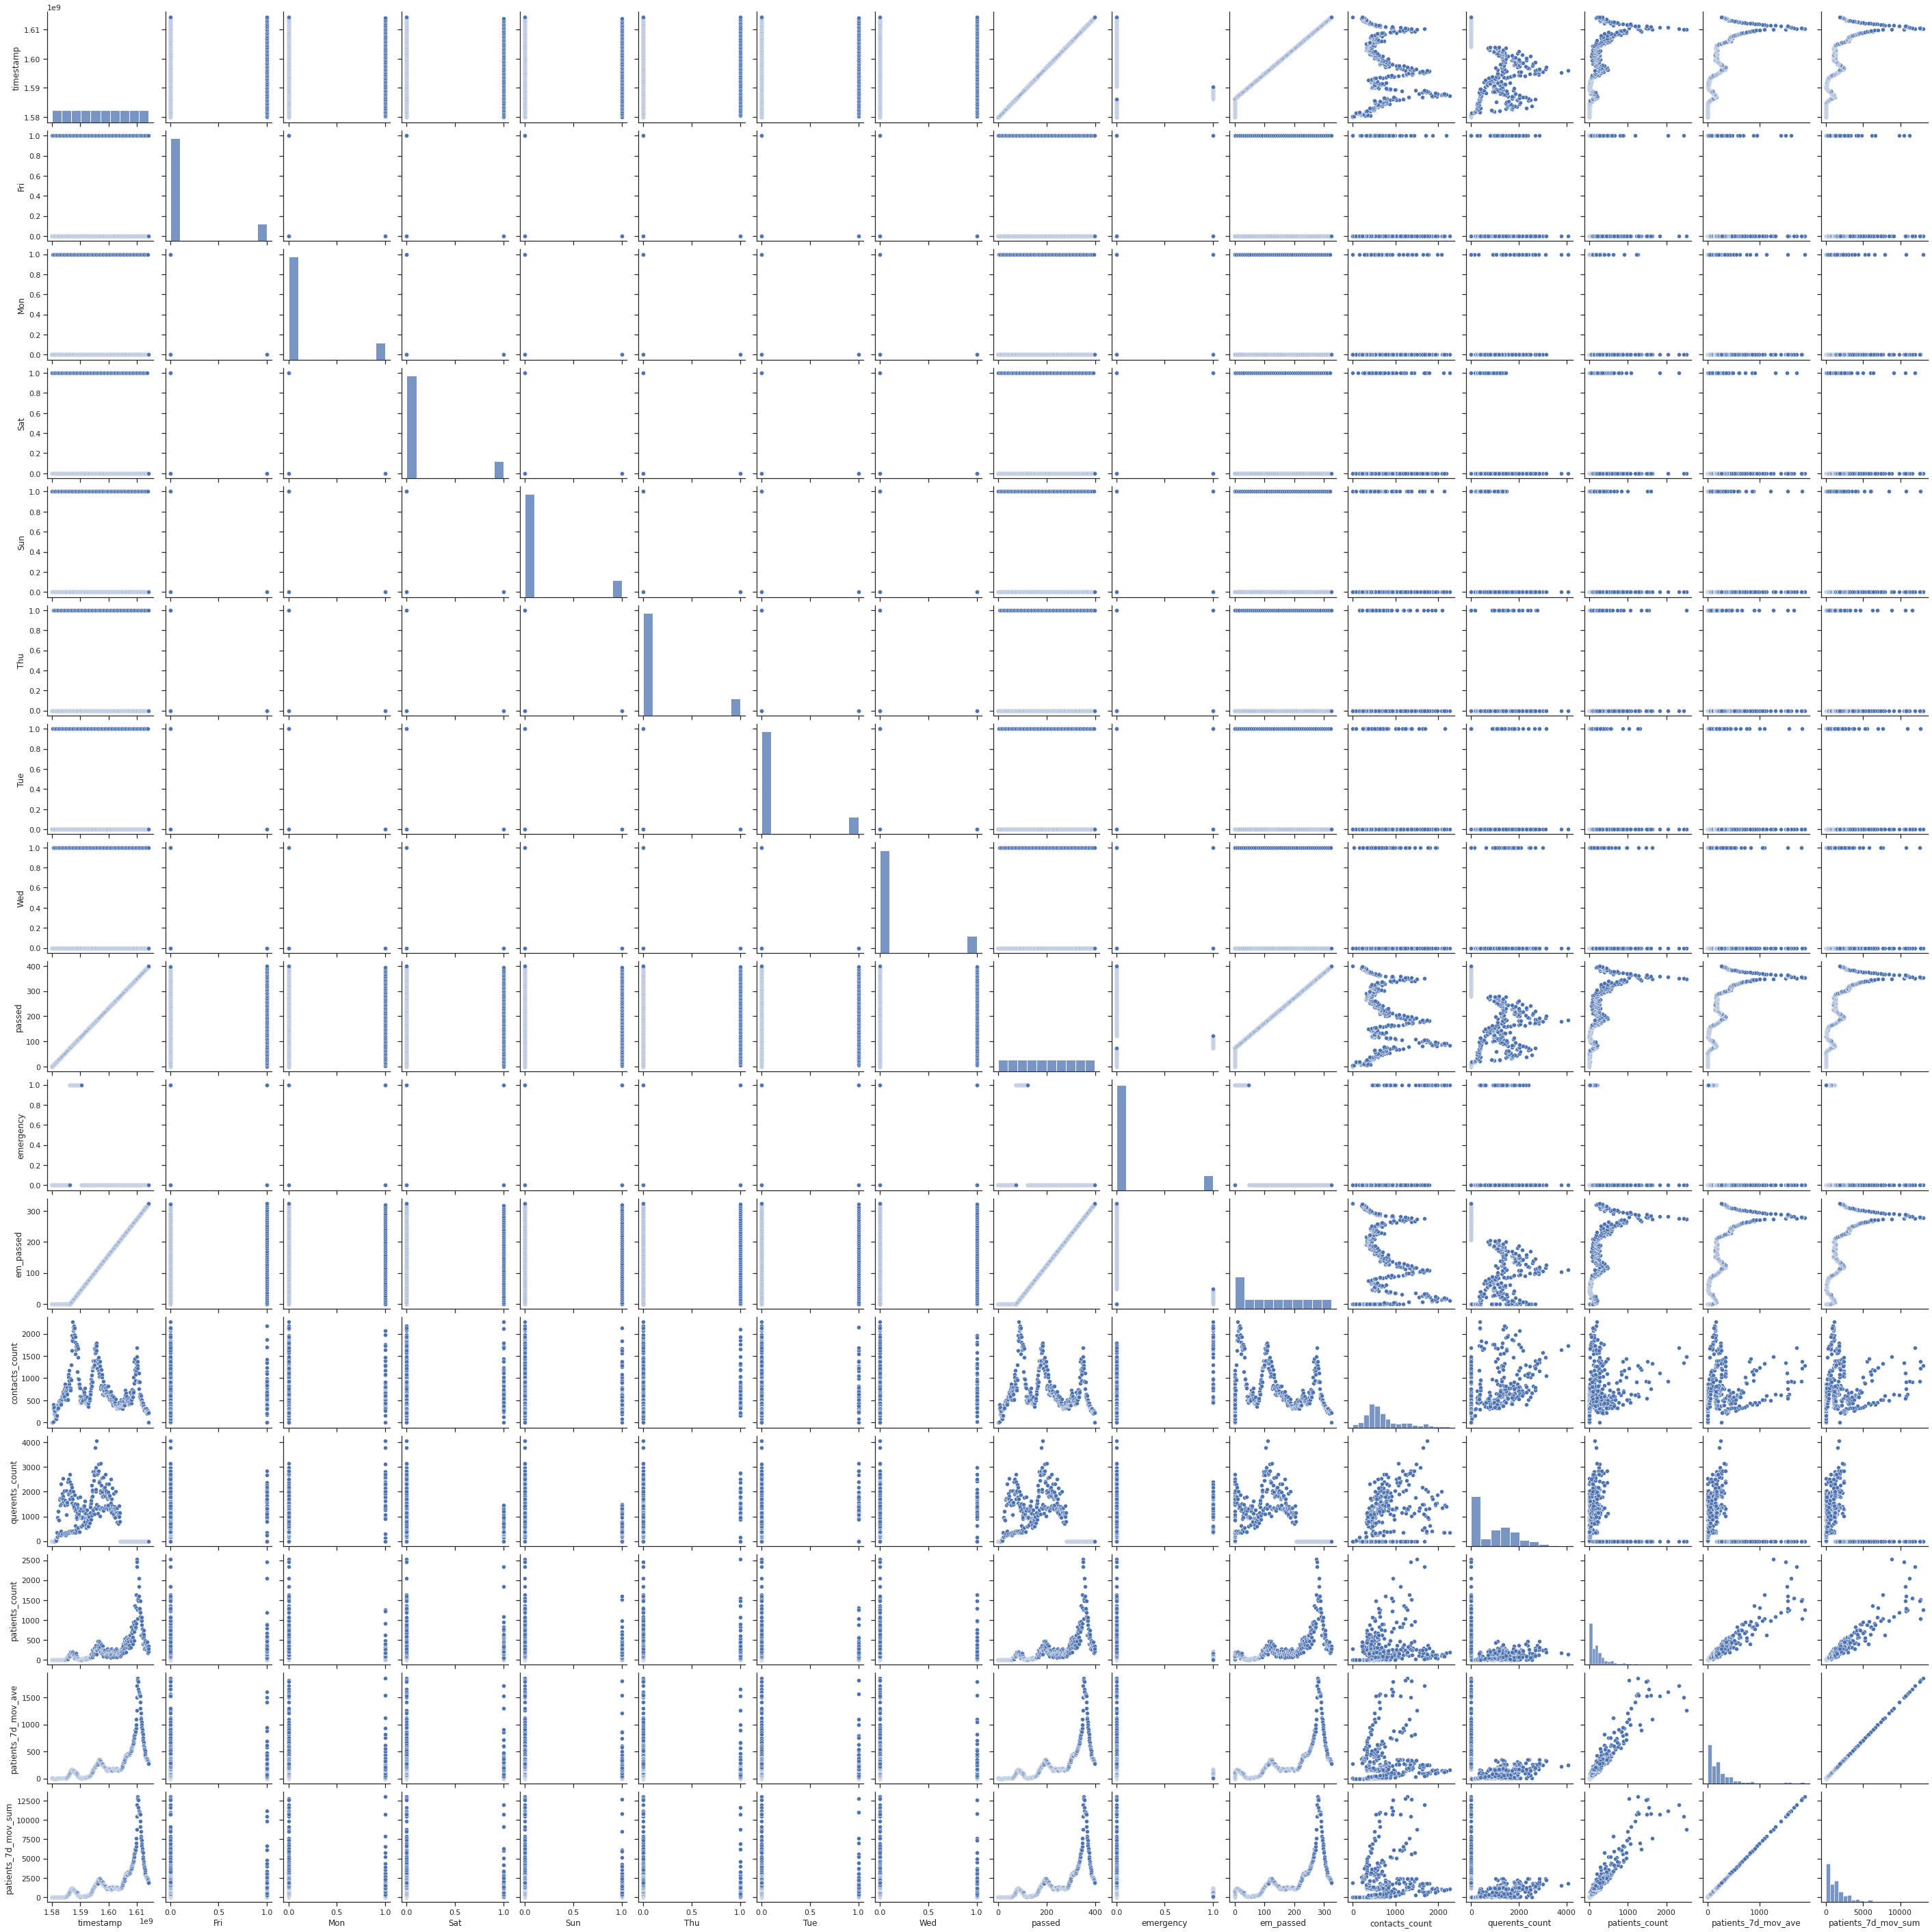

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df)

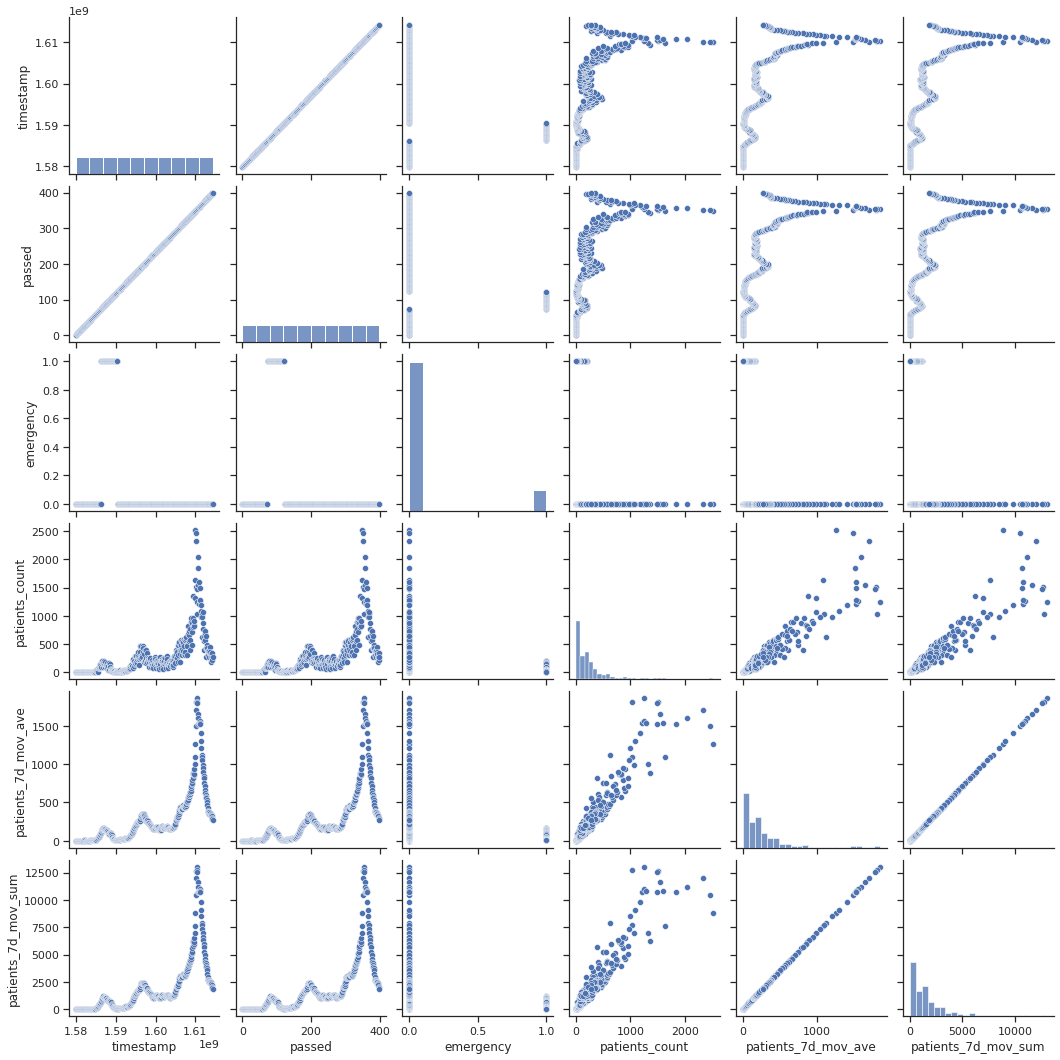

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
